In [170]:
import torch 
import torch.nn as nn 
from torch.autograd import Variable 
import torch.utils.data as Data 
import torchvision 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from torch.nn import functional as F

import math
from sklearn.model_selection import cross_val_score,train_test_split

In [171]:
df = pd.read_csv(r"C:\Users\dyy\Desktop\12.csv")
X = np.expand_dims(df.values[:, 0:8].astype(float), axis=2)#增加一维轴
X1 = df.values[:, 0:8]
Y = df.values[:, 8:229]

In [320]:
def minmaxscaler(df):
    min = np.amin(df)
    max = np.amax(df)    
    return (df - min)/(max-min)

def fan_minmaxscaler(x,df):
    min = np.amin(df)
    max = np.amax(df)    
    return x*(max-min)+ min

In [305]:

def calc_corr(a, b):
    a_avg = sum(a)/len(a)
    b_avg = sum(b)/len(b)
 
    # 计算分子，协方差————按照协方差公式，本来要除以n的，由于在相关系数中上下同时约去了n，于是可以不除以n
    cov_ab = sum([(x - a_avg)*(y - b_avg) for x,y in zip(a, b)])
 
    # 计算分母，方差乘积————方差本来也要除以n，在相关系数中上下同时约去了n，于是可以不除以n
    sq = math.sqrt(sum([(x - a_avg)**2 for x in a])*sum([(x - b_avg)**2 for x in b]))
 
    corr_factor = cov_ab/sq
 
    return corr_factor


In [173]:
X_train, X_test, Y_train, Y_test = train_test_split( minmaxscaler(X),  minmaxscaler(Y), test_size=0.2, random_state=5)

In [174]:
x_tra = Variable(torch.from_numpy(X_train))
x_tra = x_tra.float()
x_tes = Variable(torch.from_numpy(X_test))
x_tes = x_tes.float()
y_tra = Variable(torch.from_numpy(Y_train))
y_tra = y_tra.float()
y_tes = Variable(torch.from_numpy(Y_test))
y_tes = y_tes.float()
x_tra = x_tra.permute(0,2,1)
x_tes = x_tes.permute(0,2,1)


In [175]:
x_tra.shape

torch.Size([5248, 1, 8])

In [176]:
class ResBlk(nn.Module):
    def __init__(self,ch_in,ch_out,stride=1):
        super(ResBlk, self).__init__()
 
        # 两个卷积层
        self.conv1=torch.nn.Conv1d(ch_in,ch_out,kernel_size=3,stride=stride,padding=1)
        self.bn1=nn.BatchNorm1d(ch_out)
        self.conv2=torch.nn.Conv1d(ch_out,ch_out,kernel_size=3,stride=1,padding=1)
        self.bn2=nn.BatchNorm1d(ch_out)
 
        # 短接层
        self.extra=nn.Sequential()
        if ch_out != ch_in:
            self.extra=nn.Sequential(
                nn.Conv1d(ch_in,ch_out,kernel_size=1,stride=stride),
                nn.BatchNorm1d(ch_out)
            )
    def forward(self,x):
        """
        :param x: [b,ch,h,w]
        :return:
        """
        out=F.relu(self.bn1(self.conv1(x)))
        out=self.bn2(self.conv2(out))
 
        # 短接层
        # element-wise add: [b,ch_in,h,w]=>[b,ch_out,h,w]
        out=self.extra(x)+out
        return out
 

class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
         
        # 定义预处理层
        self.mlp1  =torch.nn.Sequential(
            torch.nn.Linear(8,100),
            torch.nn.ReLU(),
        )
        self.conv1=nn.Sequential(
            torch.nn.Conv1d(1,8,kernel_size=2,stride=1,padding=0),
            nn.BatchNorm1d(8)
        )
 
        # 定义堆叠ResBlock层
        # followed 4 blocks
        
        self.blk1=ResBlk(8,16,stride=1)
     
        self.blk2=ResBlk(16,32,stride=1)
     
        self.blk3=ResBlk(32,64,stride=1)
        
        self.blk4=ResBlk(64,32,stride=1)
 
        self.e0 = nn.Flatten()
        # 定义全连接层
        self.mlp2  =torch.nn.Sequential(
            torch.nn.Linear(3168,1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000,500),
            torch.nn.ReLU(),
            torch.nn.Linear(500,221),
        )
            
    def forward(self,x):
        """
        :param x:
        :return:
        """
        # 1.预处理层
    
        x = self.mlp1(x)
        x=F.relu(self.conv1(x))
        # 2. 堆叠ResBlock层：channel会慢慢的增加，  长和宽会慢慢的减少
        # [b,64,h,w]-->[b,512,h,w]

        x=self.blk1(x)
        x=self.blk2(x)
        x=self.blk3(x)
        x=self.blk4(x)
        x = self.e0(x)
        # print("after conv:",x.shape) # [b,512,2,2]
        # 不管原先什么后面两个维度是多少，都化成[1,1]，
        # [b,512,1,1]
       # x=F.adaptive_avg_pool2d(x,[1,1])
        # print("after pool2d:",x.shape) # [b,512,1,1]
 
        # 将[b,512,1,1]打平成[b,512*1*1]
        x=x.view(x.size(0),-1)
 
        # 3.放到全连接层，进行打平
        # [b,512]-->[b,10]
        #print(x.size())
        x=self.mlp2(x)
 
        return x


In [409]:
model = ResNet18()
loss_func = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(),lr=0.001)
#optim = torch.optim.Pso(model.parameters(),lr=0.001)
batch_size = 32
epochs = 20000

In [410]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [411]:
losses = []
step = 0

In [489]:
print("epoch\t loss\t")
for i in range(epochs):
     batch_loss = []
    # start和end分别是提取一个batch数据的起始和终止下标
     for start in range(0, len(x_tra), batch_size):
        end = start + batch_size if start + batch_size < len(x_tra) else len(x_tra)
        xx = torch.tensor(x_tra[start:end], dtype = torch.float, requires_grad = False).to(device)
        yy = torch.tensor(y_tra[start:end], dtype = torch.float, requires_grad = False).to(device)
        predict = model(xx)
        loss =loss_func(predict, yy)
        optim.zero_grad()
        loss.backward()
        optim.step()
        step += 1
        batch_loss.append(loss.data.cpu().numpy())
    
    # 每隔100步输出一下损失值（loss）
     if i % 100==0:
        losses.append(np.mean(batch_loss))
        print("epoch :{},step : {} , loss : {}".format(i+1,step,loss))

epoch	 loss	


<ipython-input-489-cda00c6881b7>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx = torch.tensor(x_tra[start:end], dtype = torch.float, requires_grad = False).to(device)
<ipython-input-489-cda00c6881b7>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yy = torch.tensor(y_tra[start:end], dtype = torch.float, requires_grad = False).to(device)


epoch :1,step : 309749 , loss : 0.0003239102370571345


KeyboardInterrupt: 

In [424]:
#test=pd.DataFrame(data=losses)
#test.to_csv('./loss_resnet.csv',encoding='gbk')

In [490]:
torch.save(model,"resnet.pth")

In [491]:
model_dict=torch.load("resnet.pth")

In [492]:
X_ver = minmaxscaler(X_test)
Y_ver = minmaxscaler(Y_test)

Text(0, 0.5, 's11')

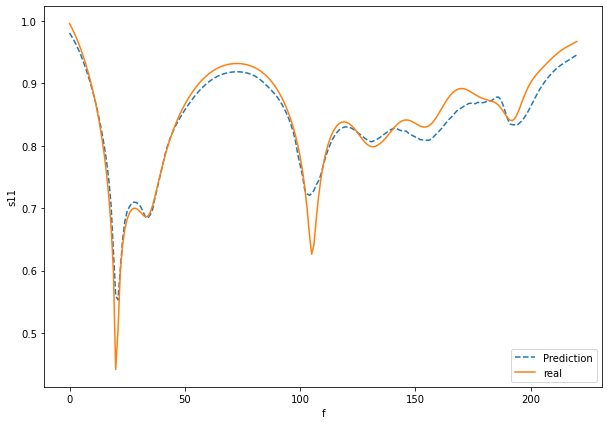

In [493]:
i =1000

x_ver = Variable(torch.from_numpy(X_ver))
x_ver = x_ver.float()
y_ver = Variable(torch.from_numpy(Y_ver))
y_ver = y_ver.float()
r=x_ver[i].unsqueeze(0)
r = r.permute(0,2,1)
predicted1 = model_dict(r.to(device))
predicted1 = predicted1.detach().cpu().numpy()
b=predicted1.squeeze(0)
fig, ax = plt.subplots(figsize = (10, 7))
#plt.scatter(X[: ,12],predicted1)
ax.plot(b, label='Prediction', linestyle = '--')
ax.plot(y_ver[i], label='real', linestyle = '-')
ax.legend()
ax.set_xlabel('f')
ax.set_ylabel('s11')

In [483]:
cor2 = calc_corr(b,y_ver[i])
cor2

tensor(0.9826)

In [448]:
e = fan_minmaxscaler(y_ver[i],Y)
a = fan_minmaxscaler(b,Y)

In [449]:
test=pd.DataFrame(data=a)
test.to_csv('./resnet_predicted1.csv',encoding='gbk')

In [75]:
#test=pd.DataFrame(data=e)
#test.to_csv('./cnn_real.csv',encoding='gbk')